In [80]:
# sqlContext <- sparkRSQL.init(sc)
sqlContext <- sparkR.session(sc)

In [81]:
# Libraries
library(ggplot2)
library(randomForest)

In [82]:
# Add data asset from file system
stores <- read.csv('../datasets/store.csv')
train <- read.csv('../datasets/train.csv')
test <- read.csv('../datasets/test.csv')
head(stores)
head(train)

Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1,c,a,1270,9,2008,0,NA,NA,
2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
4,c,c,620,9,2009,0,NA,NA,
5,a,a,29910,4,2015,0,NA,NA,
6,a,a,310,12,2013,0,NA,NA,


Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1
6,5,2015-07-31,5651,589,1,1,0,1


In [83]:
str(stores)

'data.frame':	1115 obs. of  10 variables:
 $ Store                    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ StoreType                : Factor w/ 4 levels "a","b","c","d": 3 1 1 3 1 1 1 1 1 1 ...
 $ Assortment               : Factor w/ 3 levels "a","b","c": 1 1 1 3 1 1 3 1 3 1 ...
 $ CompetitionDistance      : int  1270 570 14130 620 29910 310 24000 7520 2030 3160 ...
 $ CompetitionOpenSinceMonth: int  9 11 12 9 4 12 4 10 8 9 ...
 $ CompetitionOpenSinceYear : int  2008 2007 2006 2009 2015 2013 2013 2014 2000 2009 ...
 $ Promo2                   : int  0 1 1 0 0 0 0 0 0 0 ...
 $ Promo2SinceWeek          : int  NA 13 14 NA NA NA NA NA NA NA ...
 $ Promo2SinceYear          : int  NA 2010 2011 NA NA NA NA NA NA NA ...
 $ PromoInterval            : Factor w/ 4 levels "","Feb,May,Aug,Nov",..: 1 3 3 1 1 1 1 1 1 1 ...


In [84]:
str(train)

'data.frame':	1017209 obs. of  9 variables:
 $ Store        : int  1 2 3 4 5 6 7 8 9 10 ...
 $ DayOfWeek    : int  5 5 5 5 5 5 5 5 5 5 ...
 $ Date         : Factor w/ 942 levels "2013-01-01","2013-01-02",..: 942 942 942 942 942 942 942 942 942 942 ...
 $ Sales        : int  5263 6064 8314 13995 4822 5651 15344 8492 8565 7185 ...
 $ Customers    : int  555 625 821 1498 559 589 1414 833 687 681 ...
 $ Open         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Promo        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ StateHoliday : Factor w/ 4 levels "0","a","b","c": 1 1 1 1 1 1 1 1 1 1 ...
 $ SchoolHoliday: int  1 1 1 1 1 1 1 1 1 1 ...


In [85]:
train$Promo <- as.factor(train$Promo)
train$Open <- as.factor(train$Open)
train$DayOfWeek <- as.factor(train$DayOfWeek)
train$SchoolHoliday <- as.factor(train$SchoolHoliday)

train <- merge(train, stores)
test <- merge(test, stores)

# There are some NAs in the integer columns so conversion to zero
train[is.na(train)]   <- 0
test[is.na(test)]   <- 0

In [86]:
train.sdf <-as.DataFrame(train)

In [87]:
printSchema(train.sdf)

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: string (nullable = true)
 |-- Promo: string (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: string (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: double (nullable = true)
 |-- CompetitionOpenSinceMonth: double (nullable = true)
 |-- CompetitionOpenSinceYear: double (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: double (nullable = true)
 |-- Promo2SinceYear: double (nullable = true)
 |-- PromoInterval: string (nullable = true)


In [88]:
paste("Trainingsdaten R Dataframe:", class(train))
paste("Trainingsdaten R Dataframe:", typeof(train))
paste("Trainingsdaten SparkR Dataframe:", class(train.sdf))
paste("Trainingsdaten SparkR Dataframe:", typeof(train.sdf))

[1] "Trainingsdaten R Dataframe: data.frame"

[1] "Trainingsdaten R Dataframe: list"

[1] "Trainingsdaten SparkR Dataframe: SparkDataFrame"

[1] "Trainingsdaten SparkR Dataframe: S4"

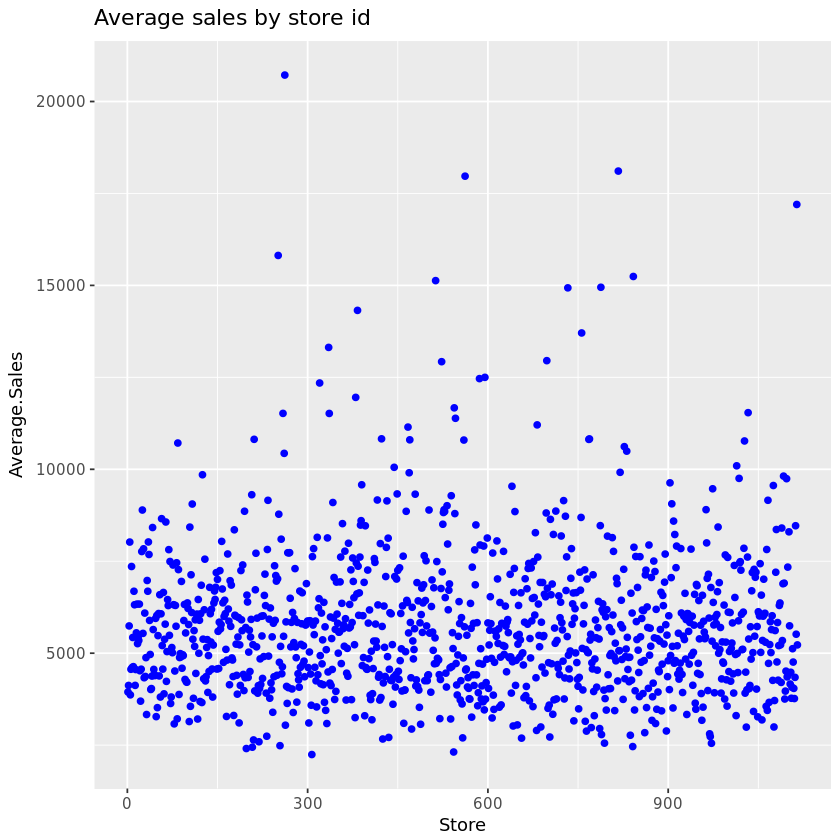

In [89]:
sales.by.store.df <- aggregate(train$Sales,by = list(train$Store),mean)
names(sales.by.store.df) <- c("Store","Average.Sales")
ggplot(data=sales.by.store.df,aes(x=Store,y=Average.Sales)) + geom_point(color="blue") + 
  ggtitle("Average sales by store id")

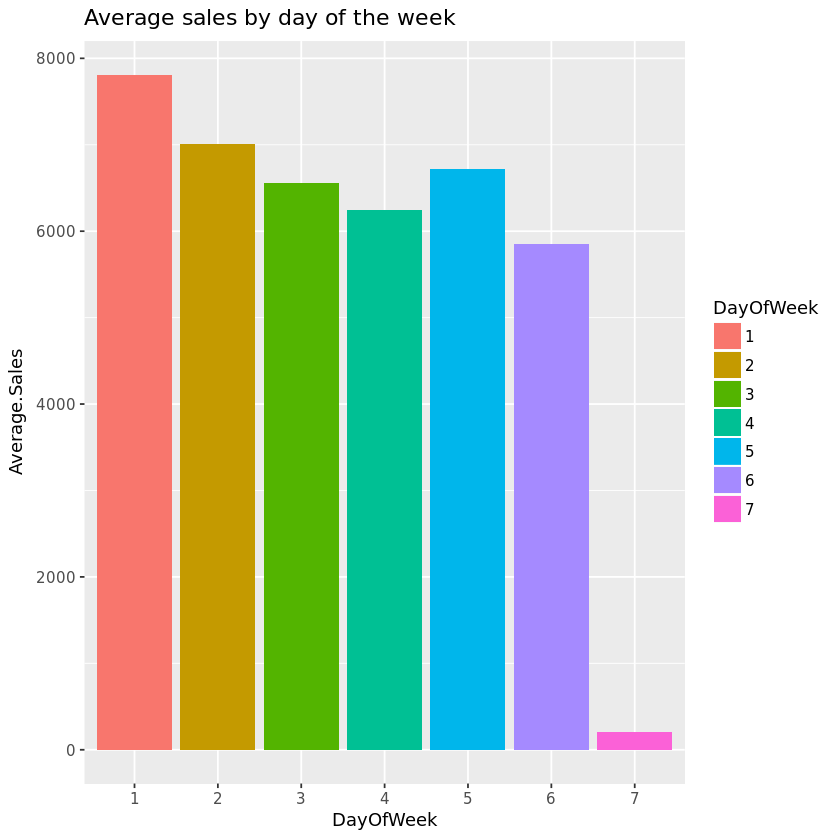

In [90]:
sales.by.day.df <- aggregate(train$Sales,by = list(train$DayOfWeek),mean)
names(sales.by.day.df) <- c("DayOfWeek","Average.Sales")
ggplot(data=sales.by.day.df,aes(x=DayOfWeek,y=Average.Sales,fill=DayOfWeek)) +
  geom_bar(stat="identity") + ggtitle("Average sales by day of the week")

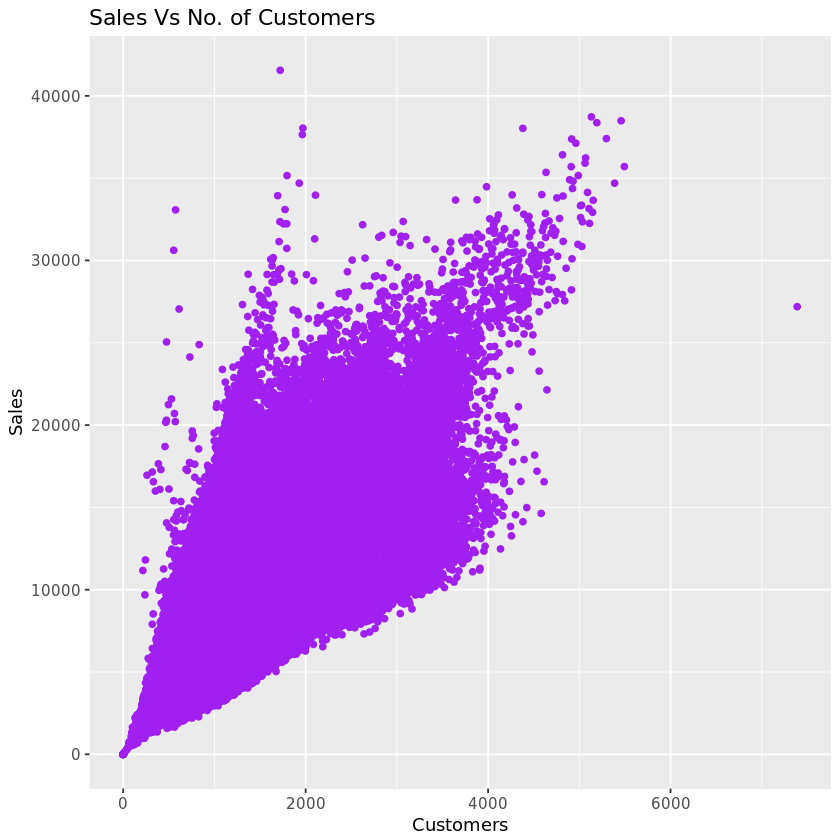

In [91]:
ggplot(data=train,aes(x=Customers,y=Sales)) + geom_point(color="purple") + ggtitle("Sales Vs No. of Customers")

In [72]:
# looking at only stores that were open in the train set
# may change this later

train <- train[ which(train$Open=='1'),]
train$Month <- as.factor(format(as.Date(train$Date),"%m"))
train$Day <- as.factor(format(as.Date(train$Date),"%d"))
train$Year <- as.factor(format(as.Date(train$Date),"%Y"))

In [74]:
# removing the date column (since elements are extracted) and also StateHoliday which has a lot of NAs (may add it back in later)
train <- train[,-c(3,8)]

# removing the date column (since elements are extracted) and also StateHoliday which has a lot of NAs (may add it back in later)
test <- test[,-c(4,7)]

In [76]:
feature.names <- names(train)[c(1,2,6,8:12,14:19)]
cat("Feature Names\n")
feature.names

Feature Names


[1] "Store"                     "DayOfWeek"                
 [3] "SchoolHoliday"             "CompetitionDistance"      
 [5] "CompetitionOpenSinceMonth" "CompetitionOpenSinceYear" 
 [7] "Promo2"                    "Promo2SinceWeek"          
 [9] "PromoInterval"             "Month"                    
[11] "Day"                       "Year"                     
[13] NA                          NA

In [77]:
cat("assuming text variables are categorical & replacing them with numeric ids\n")
for (f in feature.names) {
  if (class(train[[f]])=="character") {
    levels <- unique(c(train[[f]], test[[f]]))
    train[[f]] <- as.integer(factor(train[[f]], levels=levels))
    test[[f]]  <- as.integer(factor(test[[f]],  levels=levels))
  }
}

assuming text variables are categorical & replacing them with numeric ids


In [62]:
set.seed(2016)
feature.names <- names(train)[c(1,2,6:18)]
feature.names

[1] "Store"                     "DayOfWeek"                
 [3] "Open"                      "Promo"                    
 [5] "StateHoliday"              "SchoolHoliday"            
 [7] "StoreType"                 "Assortment"               
 [9] "CompetitionDistance"       "CompetitionOpenSinceMonth"
[11] "CompetitionOpenSinceYear"  "Promo2"                   
[13] "Promo2SinceWeek"           "Promo2SinceYear"          
[15] "PromoInterval"

In [78]:
clf <- randomForest(train[,feature.names], 
                    log(train$Sales+1),
                    mtry=5,
                    ntree=50,
                    sampsize=100000,
                    do.trace=TRUE)

ERROR: Error in `[.data.frame`(train, , feature.names): undefined columns selected


In [57]:
# Spark RandomForest Model
#spark.randomForest(train.sdf, features.names)
spark.randomForest()

ERROR: Error in spark.randomForest(): could not find function "spark.randomForest"
